# Import modules

In [5]:
# import
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from zipfile import ZipFile
from scipy import sparse
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Preprocessing

### Unzip data

In [22]:
# Extract data
def preDot(txt):
    return txt.rsplit('.', 1)[0]

np.random.seed(73)
pd.options.mode.chained_assignment = None
path = "../data/kaggle/" # Path of dataset 
dataDict = {}

for dirname, _ , filenames in os.walk(path) :
    #print(filenames)
    for filename in filenames:
        if filename.endswith('.zip'):
            print(os.path.join(dirname, filename))
            with ZipFile(os.path.join(dirname, filename), 'r') as zipf:
                unzipped_fn = preDot(filename)
                with zipf.open(unzipped_fn) as f:
                    dataDict[preDot(unzipped_fn)] = pd.read_csv(f)
train_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'train'].drop('eval_set', axis=1)
prior_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'prior'].drop('eval_set', axis=1)
test_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'test'].drop('eval_set', axis=1)

../data/kaggle/aisles.csv.zip
../data/kaggle/departments.csv.zip
../data/kaggle/orders.csv.zip
../data/kaggle/order_products__prior.csv.zip
../data/kaggle/order_products__train.csv.zip
../data/kaggle/products.csv.zip
../data/kaggle/sample_submission.csv.zip


### Exploration


In [23]:
dataDict.keys()

dict_keys(['aisles', 'departments', 'orders', 'order_products__prior', 'order_products__train', 'products', 'sample_submission'])

In [24]:
def display_head(df):
    print(df.head(),'\n')


In [25]:
for file in dataDict.keys():
    print(file,'\n')
    display_head(dataDict[file])

aisles 

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation 

departments 

   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol 

orders 

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day   
0   2539329        1    prior             1          2                  8  \
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2        

#### Exploration Data Analysis

In [58]:
dataDict.keys()

dict_keys(['aisles', 'departments', 'orders', 'order_products__prior', 'order_products__train', 'products', 'sample_submission'])

In [64]:
aisles = dataDict['aisles']
departments = dataDict['departments']
orders = dataDict['orders']
order_products__prior = dataDict['order_products__prior']
order_products__train = dataDict['order_products__train']
products = dataDict['products']
sample_submission = dataDict['sample_submission']

In [72]:
products.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object')

In [73]:
data_frame = order_products__train.merge(orders, on="order_id"
                                         ).merge(products, on="product_id"
                                                 ).merge(departments, on="department_id"
                                                         ).merge(aisles, on="aisle_id")

In [74]:
data_frame.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt


In [76]:
data_frame.shape

(1384617, 15)

Combien de fois un produit a été commander ?

In [81]:
id_c = data_frame['product_id'].value_counts()
id_c = pd.DataFrame(id_c)
id_c.reset_index(inplace=True)
id_c.columns = ['product_id', 'count']
products_frequence = id_c.merge(products, on="product_id")

In [82]:
products_frequence.head()

,product_id,count,product_name,aisle_id,department_id
0,24852,18726,Banana,24,4
1,13176,15480,Bag of Organic Bananas,24,4
2,21137,10894,Organic Strawberries,24,4
3,21903,9784,Organic Baby Spinach,123,4
4,47626,8135,Large Lemon,24,4


<Figure size 5000x4000 with 0 Axes>

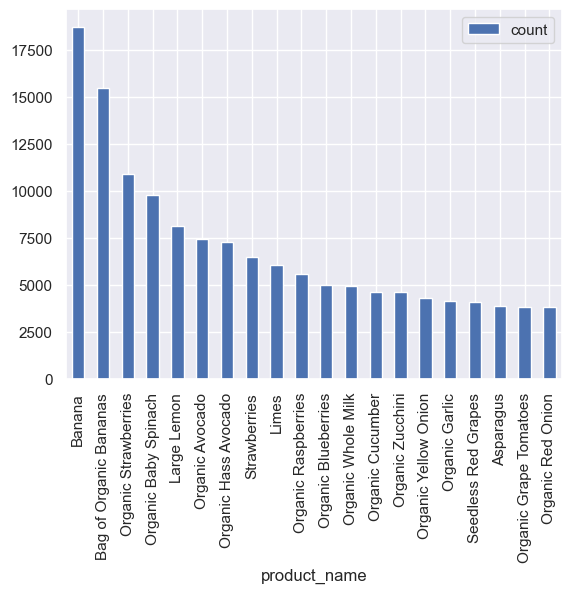

In [86]:
# Afficher les 20 premiers
sns.set()
plt.figure(figsize=(50, 40))
products_frequence.head(20).plot(kind="bar", x="product_name", y="count")
plt.show()

### Transactional Table Preparation

In [26]:
small_train_data = dataDict['order_products__train'][['order_id', 'product_id']]

In [27]:
small_train_data.shape

(1384617, 2)

In [28]:
print(f' Il y\'a {len(small_train_data.order_id.unique())} transactions et {len(small_train_data.product_id.unique())} produits')

 Il y'a 131209 transactions et 39123 produits


In [30]:
small_train_data.dtypes

order_id      int64
product_id    int64
dtype: object

In [32]:
# Table of articles
products = dataDict["products"]

In [33]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [34]:
products.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

In [36]:
products['product_name']

0                               Chocolate Sandwich Cookies
1                                         All-Seasons Salt
2                     Robust Golden Unsweetened Oolong Tea
3        Smart Ones Classic Favorites Mini Rigatoni Wit...
4                                Green Chile Anytime Sauce
                               ...                        
49683            Vodka, Triple Distilled, Twist of Vanilla
49684                   En Croute Roast Hazelnut Cranberry
49685                                     Artisan Baguette
49686           Smartblend Healthy Metabolism Dry Cat Food
49687                               Fresh Foaming Cleanser
Name: product_name, Length: 49688, dtype: object

In [37]:
# La table de transaction ne peut pas tenir dans la memeoire
# Split en 3 parties
small_train_data_split = (small_train_data[:461543],
                            small_train_data[461543:461543*2-1],
                            small_train_data[461543*2-1:])

In [43]:
small_train_data_split[0].size

923086

In [44]:
small_train_data_split[1].size

923084

In [46]:
small_train_data_split[2].size

923064

In [47]:
#prepa data pour l'efficacite de la memoire, divisé en 3 parties

pivots = []
for df in small_train_data_split :
    pvt = ~(df.pivot(index='order_id', columns='product_id', values='product_id').isna())
    pivots.append(pvt.astype(pd.SparseDtype(bool)))
del pvt

product_cols = sorted(small_train_data.product_id.unique())

In [48]:
for i in range(len(pivots)):
    pivots[i] = pivots[i].reindex(columns=product_cols, fill_value=False).astype(pd.SparseDtype(bool))
    pivots[i] = sparse.csr_matrix(pivots[i])

pivots = sparse.vstack(pivots)

truth_table=pd.DataFrame(pivots.todense(), index=small_train_data.order_id.unique(),
                        columns=product_cols)

In [49]:
truth_table.shape

(131209, 39123)

In [53]:
truth_table.head()

,1,2,3,4,5,7,8,9,10,11,...,49677,49678,49679,49680,49681,49682,49683,49686,49687,49688
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Algorithmes

### Regles d'associations

#### Apriori

Generation des itemset frequents

In [84]:
# Seuil de support
min_sup = [0.001*i for i in range(4,100,2) ]

In [85]:
freq_itemsets_ap = []
for i in min_sup:
    tmp_f = apriori(truth_table, min_support=i, use_colnames=True)
    freq_itemsets_ap.append(tmp_f)


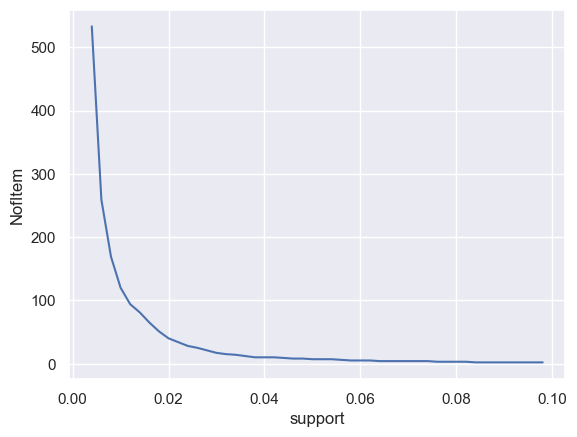

In [87]:
# Plot frequent itemset with minsup
sns.set()
y_ap = [i.shape[0] for i in freq_itemsets_ap]
X_ap = min_sup
plt.plot(X_ap,y_ap)
plt.xlabel('support')
plt.ylabel('NofItem')
plt.show()


In [88]:
freq_itemsets_ap[2].head()

,support,itemsets
0,0.011485,(196)
1,0.009260,(260)
2,0.009733,(432)
3,0.008887,(2295)
4,0.009893,(3957)


In [89]:
freq_itemsets_ap[2].shape

(169, 2)

In [90]:
# Choix apriori avec min sup = 0.8%
freq_itemsets_ap_1 =  freq_itemsets_ap[2]
freq_itemsets_ap_1['length'] = freq_itemsets_ap_1['itemsets'].apply(lambda x:len(x))
freq_itemsets_ap_1

,support,itemsets,length
0,0.011485,(196),1
1,0.009260,(260),1
2,0.009733,(432),1
3,0.008887,(2295),1
4,0.009893,(3957),1
...,...,...,...
164,0.009382,"(45066, 24852)",2
165,0.016447,"(47626, 24852)",2
166,0.016889,"(24852, 47766)",2
167,0.012156,"(26209, 47626)",2


Generer des regles

In [91]:
min_sup_c = 0.001
min_conf_c = 0.95

In [92]:
rules_aprioi = association_rules(freq_itemsets_ap_1, metric='support', min_threshold=min_sup_c)

In [93]:
rules_aprioi

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(24852),(4605),0.142719,0.028672,0.008163,0.057193,1.994754,0.004071,1.030252,0.581705
1,(4605),(24852),0.028672,0.142719,0.008163,0.284689,1.994754,0.004071,1.198473,0.513405
2,(4920),(24852),0.030935,0.142719,0.008856,0.286277,2.005883,0.004441,1.201141,0.517475
3,(24852),(4920),0.142719,0.030935,0.008856,0.062053,2.005883,0.004441,1.033176,0.584950
4,(13176),(5876),0.117980,0.026713,0.008132,0.068928,2.580293,0.004980,1.045340,0.694369
5,(5876),(13176),0.026713,0.117980,0.008132,0.304422,2.580293,0.004980,1.268040,0.629257
6,(13176),(21137),0.117980,0.083028,0.023428,0.198579,2.391714,0.013633,1.144183,0.659724
7,(21137),(13176),0.083028,0.117980,0.023428,0.282174,2.391714,0.013633,1.228738,0.634577
8,(13176),(21903),0.117980,0.074568,0.017042,0.144444,1.937082,0.008244,1.081674,0.548468
9,(21903),(13176),0.074568,0.117980,0.017042,0.228536,1.937082,0.008244,1.143308,0.522739


In [26]:
rules_aprioi.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(24852),(4605),0.142719,0.028672,0.008163,0.057193,1.994754,0.004071,1.030252
1,(4605),(24852),0.028672,0.142719,0.008163,0.284689,1.994754,0.004071,1.198473
2,(4920),(24852),0.030935,0.142719,0.008856,0.286277,2.005883,0.004441,1.201141
3,(24852),(4920),0.142719,0.030935,0.008856,0.062053,2.005883,0.004441,1.033176
4,(13176),(5876),0.117980,0.026713,0.008132,0.068928,2.580293,0.004980,1.045340


In [94]:
rules_aprioi.sort_values(by='confidence',ascending=False)[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
48,(28204),(24852),0.024823,0.142719,0.009222,0.371508,2.603072,0.005679,1.364028,0.631515
50,(45066),(24852),0.027064,0.142719,0.009382,0.346663,2.428991,0.005519,1.312157,0.604671
19,(47209),(13176),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044,0.682381
13,(27966),(13176),0.042268,0.117980,0.013566,0.320952,2.720400,0.008579,1.298907,0.660318
5,(5876),(13176),0.026713,0.117980,0.008132,0.304422,2.580293,0.004980,1.268040,0.629257
31,(27966),(21137),0.042268,0.083028,0.012728,0.301118,3.626710,0.009218,1.312056,0.756233
25,(16797),(24852),0.049494,0.142719,0.014847,0.299969,2.101819,0.007783,1.224633,0.551518
55,(47766),(24852),0.056467,0.142719,0.016889,0.299096,2.095698,0.008830,1.223107,0.554122
2,(4920),(24852),0.030935,0.142719,0.008856,0.286277,2.005883,0.004441,1.201141,0.517475
1,(4605),(24852),0.028672,0.142719,0.008163,0.284689,1.994754,0.004071,1.198473,0.513405


Predictions

In [100]:
rules_ante_cons = rules_aprioi[['antecedents', 'consequents']]

In [95]:
baskets = small_train_data.groupby('order_id')['product_id'].apply(frozenset)

In [96]:
baskets

order_id
1          (11109, 10246, 47209, 43633, 49683, 22035, 493...
36         (34497, 46979, 48679, 19660, 43086, 49235, 396...
38         (42625, 23622, 11913, 28842, 4461, 39693, 1815...
96         (40706, 24489, 25610, 39275, 30391, 20574, 27966)
98         (46720, 24964, 4357, 43654, 18441, 36364, 3406...
                                 ...                        
3421049           (40800, 34243, 17706, 33424, 26800, 17299)
3421056                    (21709, 12432, 5750, 16475, 9340)
3421058    (34466, 6244, 6858, 32650, 30316, 15629, 35578...
3421063                         (14233, 49235, 35548, 13565)
3421070                                 (16953, 4724, 35951)
Name: product_id, Length: 131209, dtype: object

In [97]:
baskets.name = 'basket'

In [98]:
recommendations = train_orders.join(baskets, on='order_id')
recommendations['recommendations'] = [frozenset() for _ in range(len(recommendations))]

In [101]:
for idx, antecedent in enumerate(rules_ante_cons["antecedents"]):
    lookup = antecedent <= recommendations.basket, "recommendations"
    recommendations.loc[lookup] = recommendations.loc[lookup].apply(
        frozenset.union,
        args=(rules_ante_cons.loc[idx, "consequents"],)
    )

In [102]:
recommendations.loc[:, "recommendations"] = recommendations.recommendations - recommendations.basket

In [103]:
# non-empty recommendations
non_empty_recs = recommendations[recommendations.recommendations.apply(bool)]
print("1 out of approx.", round(1/(len(non_empty_recs) / len(recommendations))), "transactions will result in a recommendation being suggested to a customer.")
# mapping codes to product names
def map_products(codes):
    if isinstance(codes, pd.Series):
        return codes.apply(map_products)
    return frozenset(map(products.get, codes))

products = dataDict["products"]
products = products.set_index("product_id")["product_name"].to_dict()
non_empty_recs.loc[:, ["basket", "recommendations"]] = non_empty_recs[["basket", "recommendations"]].apply(map_products)
print(non_empty_recs)

1 out of approx. 2 transactions will result in a recommendation being suggested to a customer.
         order_id  user_id  order_number  order_dow  order_hour_of_day   
10        1187899        1            11          4                  8  \
25        1492625        2            15          1                 11   
74         525192        7            21          2                 11   
78         880375        8             4          1                 14   
200       2180313       17            41          3                 10   
...           ...      ...           ...        ...                ...   
3420786   3383615   206196             5          0                 15   
3420862    943915   206200            24          6                 19   
3420924   2371631   206203             6          4                 19   
3420933   1716008   206205             4          1                 16   
3421082    272231   206209            14          6                 14   

         days_si

In [37]:
# a redefinir
def arl_recommender(rules_df, product):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i, antecedent in enumerate(sorted_rules["antecedents"]):
        if product in antecedent:
            recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])
    return recommendation_list


In [38]:

arl_recommender(rules_aprioi, 28204)

[24852]

In [39]:
arl_recommender(rules_aprioi, 24852)

[28204, 45066, 16797, 47766, 4920, 4605, 47626, 26209, 21903, 21137]

#### FPGrowth

* Memory test

In [40]:
tmp_g = fpgrowth(truth_table, min_support=0.0001, use_colnames=True)

In [41]:
tmp_g

,support,itemsets
0,0.117980,(13176)
1,0.055583,(47209)
2,0.018391,(49683)
3,0.015190,(22035)
4,0.008094,(10246)
...,...,...
136389,0.000191,"(17630, 895)"
136390,0.000122,"(24852, 895)"
136391,0.000122,"(18987, 44870)"
136392,0.000107,"(42345, 42085)"


In [42]:
tmp_a = apriori(truth_table, min_support=0.0001, use_colnames=True)

MemoryError: Unable to allocate 15.9 TiB for an array with shape (66741681, 2, 131209) and data type bool

Frequent itemset

In [43]:
freq_itemsets_fpg = []
for i in min_sup:
    tmp_f = fpgrowth(truth_table, min_support=i, use_colnames=True)
    freq_itemsets_fpg.append(tmp_f)

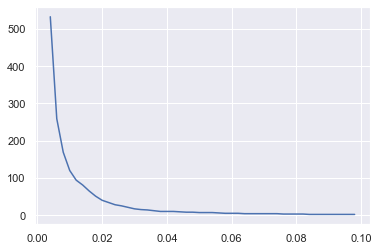

In [44]:
# Plot frequent itemset with minsup
y_fpg = [i.shape[0] for i in freq_itemsets_fpg]
X_fpg = min_sup
plt.plot(X_fpg,y_fpg)
plt.show()


In [45]:
freq_itemsets_fpg1 = freq_itemsets_fpg[2]
freq_itemsets_fpg1.head()

,support,itemsets
0,0.117980,(13176)
1,0.055583,(47209)
2,0.018391,(49683)
3,0.015190,(22035)
4,0.008094,(10246)


In [46]:
freq_itemsets_fpg1.shape

(169, 2)

In [47]:
freq_itemsets_fpg1['length'] = freq_itemsets_fpg1['itemsets'].apply(lambda x:len(x))
freq_itemsets_fpg1

,support,itemsets,length
0,0.117980,(13176),1
1,0.055583,(47209),1
2,0.018391,(49683),1
3,0.015190,(22035),1
4,0.008094,(10246),1
...,...,...,...
164,0.010281,"(47626, 47766)",2
165,0.008155,"(13176, 47766)",2
166,0.008856,"(4920, 24852)",2
167,0.009222,"(28204, 24852)",2


Generer des règles

In [48]:
rules_fpg = association_rules(freq_itemsets_fpg1, metric='support', min_threshold=min_sup_c)

In [49]:
rules_fpg

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(13176),(47209),0.117980,0.055583,0.018444,0.156331,2.812560,0.011886,1.119416
1,(47209),(13176),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044
2,(47209),(21137),0.055583,0.083028,0.011729,0.211024,2.541609,0.007114,1.162231
3,(21137),(47209),0.083028,0.055583,0.011729,0.141270,2.541609,0.007114,1.099784
4,(47209),(21903),0.055583,0.074568,0.009542,0.171671,2.302212,0.005397,1.117228
5,(21903),(47209),0.074568,0.055583,0.009542,0.127964,2.302212,0.005397,1.083002
6,(13176),(27966),0.117980,0.042268,0.013566,0.114987,2.720400,0.008579,1.082167
7,(27966),(13176),0.042268,0.117980,0.013566,0.320952,2.720400,0.008579,1.298907
8,(21137),(27966),0.083028,0.042268,0.012728,0.153295,3.626710,0.009218,1.131128
9,(27966),(21137),0.042268,0.083028,0.012728,0.301118,3.626710,0.009218,1.312056


In [50]:
rules_fpg.sort_values(by='confidence', ascending=False)[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
56,(28204),(24852),0.024823,0.142719,0.009222,0.371508,2.603072,0.005679,1.364028
40,(45066),(24852),0.027064,0.142719,0.009382,0.346663,2.428991,0.005519,1.312157
1,(47209),(13176),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044
7,(27966),(13176),0.042268,0.117980,0.013566,0.320952,2.720400,0.008579,1.298907
17,(5876),(13176),0.026713,0.117980,0.008132,0.304422,2.580293,0.004980,1.268040
9,(27966),(21137),0.042268,0.083028,0.012728,0.301118,3.626710,0.009218,1.312056
23,(16797),(24852),0.049494,0.142719,0.014847,0.299969,2.101819,0.007783,1.224633
47,(47766),(24852),0.056467,0.142719,0.016889,0.299096,2.095698,0.008830,1.223107
54,(4920),(24852),0.030935,0.142719,0.008856,0.286277,2.005883,0.004441,1.201141
59,(4605),(24852),0.028672,0.142719,0.008163,0.284689,1.994754,0.004071,1.198473


Test pour 0.0001 de support

In [51]:
tmp_g.shape

(136394, 2)

In [52]:
tmp_g['length'] = tmp_g['itemsets'].apply(lambda x:len(x))
tmp_g

,support,itemsets,length
0,0.117980,(13176),1
1,0.055583,(47209),1
2,0.018391,(49683),1
3,0.015190,(22035),1
4,0.008094,(10246),1
...,...,...,...
136389,0.000191,"(17630, 895)",2
136390,0.000122,"(24852, 895)",2
136391,0.000122,"(18987, 44870)",2
136392,0.000107,"(42345, 42085)",2


In [53]:
tmp_rules = association_rules(tmp_g, metric='support', min_threshold=min_sup_c)

In [55]:
tmp_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(13176),(47209),0.117980,0.055583,0.018444,0.156331,2.812560,0.011886,1.119416
1,(47209),(13176),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044
2,(47209),(21137),0.055583,0.083028,0.011729,0.211024,2.541609,0.007114,1.162231
3,(21137),(47209),0.083028,0.055583,0.011729,0.141270,2.541609,0.007114,1.099784
4,(47209),(21903),0.055583,0.074568,0.009542,0.171671,2.302212,0.005397,1.117228
...,...,...,...,...,...,...,...,...,...
6841,(39947),(12576),0.003948,0.003544,0.001014,0.256757,72.449026,0.001000,1.340686
6842,(24852),(3599),0.142719,0.004161,0.001151,0.008064,1.937773,0.000557,1.003934
6843,(3599),(24852),0.004161,0.142719,0.001151,0.276557,1.937773,0.000557,1.185001
6844,(21137),(3599),0.083028,0.004161,0.001014,0.012209,2.933832,0.000668,1.008147


## Heuristic method

## SARL : scalable association rule learning

## Tree ensemble : XGBoost

In [58]:
df_order_products = pd.merge(dataDict['order_products__train'],dataDict['orders'], on = 'order_id') 

In [59]:
df_order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [60]:
df_order_products.dropna()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0
...,...,...,...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,169679,train,30,0,10,4.0
1384613,3421063,35548,4,1,169679,train,30,0,10,4.0
1384614,3421070,35951,1,1,139822,train,15,6,10,8.0
1384615,3421070,16953,2,1,139822,train,15,6,10,8.0


In [62]:
X = df_order_products[['user_id',
                       'product_id',
                       'add_to_cart_order',
                       'order_number',
                       'order_dow',
                       'order_hour_of_day']]
y = df_order_products.reordered

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [66]:
xgb = XGBClassifier()

param_grid = {
    'max_depth' : [1, 2, 3, 4],
    'learning_rate' : [0.001, 0.01, 0.1, 0,3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [100]
}

clf = RandomizedSearchCV(xgb, param_grid, n_iter=10, n_jobs= -1, verbose=2, cv=3, random_state=1)

In [67]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.1, 0,
                                                          3],
                                        'max_depth': [1, 2, 3, 4],
                                        'n_estimators': [100],
                                        'reg_lambda': [0.1, 1.0, 5.0, 10.0,
                                                       50.0, 100.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=1, verbose=2)

In [68]:
y_pred = clf.predict(X_test)

In [70]:
acc = accuracy_score(y_test, y_pred)
f1_ = f1_score(y_test, y_pred)

In [72]:
print(f'Accuracy : {acc}\nF1_score : {f1_}')

Accuracy : 0.6595564125897359
F1_score : 0.7415503633706984


- tracer la courbe roc
- effectuer des predictions en fonc de nouvelles valeurs
- Ajouter d'autres methodes d'ensemble

## Deep Clustering